In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import os
import scipy.io
import glob
import scipy.misc as misc
import warnings
from distutils.version import LooseVersion
import helper
import project_tests as tests
import skimage
from matplotlib import pyplot as plt

In [2]:
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 1.8.0


In [3]:
# Check for a GPU
if not tf.test.gpu_device_name():
  warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
  print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


In [4]:
DATA_DIRECTORY = './data'
RUNS_DIRECTORY = './runs'
TRAINING_DATA_DIRECTORY ='./data/data_liquid/training'
NUMBER_OF_IMAGES = len(glob.glob('./data/data_liquid/testing/image_2/*.*'))
VGG_PATH = './data/vgg'

In [5]:
NUMBER_OF_CLASSES = 2
IMAGE_SHAPE = (480, 640)

EPOCHS = 4
BATCH_SIZE = 1

LEARNING_RATE = 0.0001
DROPOUT = 0.75

In [6]:
correct_label = tf.placeholder(tf.float32, [None, IMAGE_SHAPE[0], IMAGE_SHAPE[1], NUMBER_OF_CLASSES])
learning_rate = tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32)

In [7]:
# Used for plotting to visualize if our training is going well given parameters
all_training_losses = []

In [8]:
def load_vgg(sess, vgg_path):
  """
  Load Pretrained VGG Model into TensorFlow.
  sess: TensorFlow Session
  vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
  return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3, layer4, layer7)
  """
  # load the model and weights
  model = tf.saved_model.loader.load(sess, ['vgg16'], vgg_path)

  # Get Tensors to be returned from graph
  graph = tf.get_default_graph()
  image_input = graph.get_tensor_by_name('image_input:0')
  keep_prob = graph.get_tensor_by_name('keep_prob:0')
  layer3 = graph.get_tensor_by_name('layer3_out:0')
  layer4 = graph.get_tensor_by_name('layer4_out:0')
  layer7 = graph.get_tensor_by_name('layer7_out:0')

  return image_input, keep_prob, layer3, layer4, layer7

In [9]:
def conv_1x1(layer, layer_name):
  """ Return the output of a 1x1 convolution of a layer """
  return tf.layers.conv2d(inputs = layer,
                          filters =  NUMBER_OF_CLASSES,
                          kernel_size = (1, 1),
                          strides = (1, 1),
                          name = layer_name)

In [10]:
def upsample(layer, k, s, layer_name):
  """ Return the output of transpose convolution given kernel_size k and strides s """
  # See: http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html#transposed-convolution-arithmetic
  return tf.layers.conv2d_transpose(inputs = layer,
                                    filters = NUMBER_OF_CLASSES,
                                    kernel_size = (k, k),
                                    strides = (s, s),
                                    padding = 'same',
                                    name = layer_name)

In [11]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes = NUMBER_OF_CLASSES):
  """
  Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
  vgg_layerX_out: TF Tensor for VGG Layer X output
  num_classes: Number of classes to classify
  return: The Tensor for the last layer of output
  """

  # Use a shorter variable name for simplicity
  layer3, layer4, layer7 = vgg_layer3_out, vgg_layer4_out, vgg_layer7_out

  # Apply a 1x1 convolution to encoder layers
  layer3x = conv_1x1(layer = layer3, layer_name = "layer3conv1x1")
  layer4x = conv_1x1(layer = layer4, layer_name = "layer4conv1x1")
  layer7x = conv_1x1(layer = layer7, layer_name = "layer7conv1x1")
 
  # Add decoder layers to the network with skip connections and upsampling
  # Note: the kernel size and strides are the same as the example in Udacity Lectures
  #       Semantic Segmentation Scene Understanding Lesson 10-9: FCN-8 - Decoder
  decoderlayer1 = upsample(layer = layer7x, k = 4, s = 2, layer_name = "decoderlayer1")
  decoderlayer2 = tf.add(decoderlayer1, layer4x, name = "decoderlayer2")
  decoderlayer3 = upsample(layer = decoderlayer2, k = 4, s = 2, layer_name = "decoderlayer3")
  decoderlayer4 = tf.add(decoderlayer3, layer3x, name = "decoderlayer4")
  decoderlayer_output = upsample(layer = decoderlayer4, k = 16, s = 8, layer_name = "decoderlayer_output")

  return decoderlayer_output

In [12]:
def layers_verbose(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes = NUMBER_OF_CLASSES):

  # Use a shorter variable name for simplicity
  layer3, layer4, layer7 = vgg_layer3_out, vgg_layer4_out, vgg_layer7_out

  # Apply a 1x1 convolution to encoder layers
  layer3x = conv_1x1(layer = layer3, layer_name = "layer3conv1x1")
  layer4x = conv_1x1(layer = layer4, layer_name = "layer4conv1x1")
  layer7x = conv_1x1(layer = layer7, layer_name = "layer7conv1x1")
 
  decoderlayer1 = upsample(layer = layer7x, k = 4, s = 2, layer_name = "decoderlayer1")
  decoderlayer2 = tf.add(decoderlayer1, layer4x, name = "decoderlayer2")
  decoderlayer3 = upsample(layer = decoderlayer2, k = 4, s = 2, layer_name = "decoderlayer3")
  decoderlayer4 = tf.add(decoderlayer3, layer3x, name = "decoderlayer4")
  decoderlayer_output = upsample(layer = decoderlayer4, k = 16, s = 8, layer_name = "decoderlayer_output")

  return layer3, layer4, layer7, layer3x, layer4x, layer7x, \
         decoderlayer1, decoderlayer2, decoderlayer3, decoderlayer4, decoderlayer_output


In [13]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes = NUMBER_OF_CLASSES):
  """
  Build the TensorFLow loss and optimizer operations.
  nn_last_layer: TF Tensor of the last layer in the neural network
  correct_label: TF Placeholder for the correct label image
  learning_rate: TF Placeholder for the learning rate
  num_classes: Number of classes to classify
  return: Tuple of (logits, train_op, cross_entropy_loss)
  """
  # reshape 4D tensors to 2D
  # Each row represents a pixel, each column a class
  logits = tf.reshape(nn_last_layer, (-1, num_classes))
  class_labels = tf.reshape(correct_label, (-1, num_classes))

  # The cross_entropy_loss is the cost which we are trying to minimize to yield higher accuracy
  cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = class_labels)
  cross_entropy_loss = tf.reduce_mean(cross_entropy)

  # The model implements this operation to find the weights/parameters that would yield correct pixel labels
  train_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy_loss)

  return logits, train_op, cross_entropy_loss

In [14]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op,
             cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
  """
  Train neural network and print out the loss during training.
  sess: TF Session
  epochs: Number of epochs
  batch_size: Batch size
  get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
  train_op: TF Operation to train the neural network
  cross_entropy_loss: TF Tensor for the amount of loss
  input_image: TF Placeholder for input images
  correct_label: TF Placeholder for label images
  keep_prob: TF Placeholder for dropout keep probability
  learning_rate: TF Placeholder for learning rate
  """

  for epoch in range(EPOCHS):
    
    losses, i = [], 0
    
    for images, labels in get_batches_fn(BATCH_SIZE):
        
      i += 1
    
      feed = { input_image: images,
               correct_label: labels,
               keep_prob: DROPOUT,
               learning_rate: LEARNING_RATE }
        
      _, partial_loss = sess.run([train_op, cross_entropy_loss], feed_dict = feed)
      
      print("---> iteration: ", i, " partial loss:", partial_loss)
      losses.append(partial_loss)
          
    training_loss = sum(losses) / len(losses)
    all_training_losses.append(training_loss)
    
    print("------------------")
    print("epoch: ", epoch + 1, " of ", EPOCHS, "training loss: ", training_loss)
    print("------------------")

In [15]:
def run_tests():
  tests.test_layers(layers)
  tests.test_optimize(optimize)
  tests.test_for_kitti_dataset(DATA_DIRECTORY)
  tests.test_train_nn(train_nn)

In [16]:
def run():
  print("NUMBER OF IMAGES:", NUMBER_OF_IMAGES)

  # download vgg model
  helper.maybe_download_pretrained_vgg(DATA_DIRECTORY)

  # A function to get batches
  get_batches_fn = helper.gen_batch_function(TRAINING_DATA_DIRECTORY, IMAGE_SHAPE)

 
  
  with tf.Session() as session:
        
    # Returns the three layers, keep probability and input layer from the vgg architecture
    image_input, keep_prob, layer3, layer4, layer7 = load_vgg(session, VGG_PATH)

    # The resulting network architecture, adding a decoder on top of the given vgg model
    model_output = layers(layer3, layer4, layer7, NUMBER_OF_CLASSES)

    # Returns the output logits, training operation and cost operation to be used
    # For the logits: each row represents a pixel, each column a class
    # training operation is what is used to get the right parameters to the model to correctly label the pixels
    # the cross entropy loss is the cost which we are minimizing, lower cost should yield higher accuracy
    logits, train_op, cross_entropy_loss = optimize(model_output, correct_label, learning_rate, NUMBER_OF_CLASSES)
    
    # Initilize all variables
    session.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
    
    # Create saver
    saver = tf.train.Saver()

    # train the neural network
    train_nn(session, EPOCHS, BATCH_SIZE, get_batches_fn, 
             train_op, cross_entropy_loss, image_input,
             correct_label, keep_prob, learning_rate)
    
    # Save inference data
    helper.save_inference_samples(RUNS_DIRECTORY, DATA_DIRECTORY, session, IMAGE_SHAPE, logits, keep_prob, image_input)    
    
    # Save model
    saver.save(session, "./model.ckpt")

In [17]:
def network_shapes():
  with tf.Session() as sess:
    x = np.random.randn(1, 160, 576, 3)
    
    image_input, keep_prob, layer3, layer4, layer7 = load_vgg(sess, VGG_PATH)
 
    op = layers_verbose(layer3, layer4, layer7, NUMBER_OF_CLASSES)
  
    sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])

    l3, l4, l7, l3x, l4x, l7x, d1, s2, d3, s4, d5 = sess.run(op, feed_dict = {image_input: x, keep_prob: 1.0})

    print("------------------")
    print("shapes of layers:") 
    print("------------------")

    print("layer3 -->", l3.shape)
    print("layer4 -->", l4.shape)
    print("layer7 -->", l7.shape)
    print("layer3 conv1x1 -->", l3x.shape)
    print("layer4 conv1x1 -->", l4x.shape)
    print("layer7 conv1x1-->", l7x.shape)
    print("decoderlayer1 transpose: layer7 k = 4 s = 2 -->", d1.shape)
    print("decoderlayer2 skip: decoderlayer1 and layer4conv1x1 -->", s2.shape)
    print("decoderlayer3 transpose: decoderlayer2 k = 4 s = 2 -->", d3.shape)
    print("decoderlayer4 skip: decoderlayer3 and layer3conv1x1 -->", s4.shape)
    print("decoderlayer5 transpose: decoderlayer4 k = 16 s = 8 -->", d5.shape)

In [18]:
# Train the network
run()

NUMBER OF IMAGES: 509
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

---> iteration:  1  partial loss: 44.186672
---> iteration:  2  partial loss: 32.591442
---> iteration:  3  partial loss: 26.558313
---> iteration:  4  partial loss: 21.260292
---> iteration:  5  partial loss: 16.799559
---> iteration:  6  partial loss: 15.143177
---> iteration:  7  partial loss: 13.194686
---> iteration:  8  partial loss: 11.193658
---> iteration:  9  partial loss: 10.10008
---> iteration:  10  partial loss: 9.128002
---> iteration:  11  partial loss: 8.299973
---> iteration:  12  partial loss: 7.1874285
---> iteration:  13  partial loss: 6.4994206
---> iteration:  14  partial loss: 5.751092
---> iteration:  15  partial loss: 5.2759542
---> iteration:  16  partial loss: 5.0562205
---

---> iteration:  171  partial loss: 0.69248563
---> iteration:  172  partial loss: 0.68717074
---> iteration:  173  partial loss: 0.68328214
---> iteration:  174  partial loss: 0.6812946
---> iteration:  175  partial loss: 0.6832227
---> iteration:  176  partial loss: 0.67672366
---> iteration:  177  partial loss: 0.679287
---> iteration:  178  partial loss: 0.6824694
---> iteration:  179  partial loss: 0.6797212
---> iteration:  180  partial loss: 0.6755581
---> iteration:  181  partial loss: 0.6747755
---> iteration:  182  partial loss: 0.67853403
---> iteration:  183  partial loss: 0.6770606
---> iteration:  184  partial loss: 0.67380464
---> iteration:  185  partial loss: 0.6702652
---> iteration:  186  partial loss: 0.6707224
---> iteration:  187  partial loss: 0.67349505
---> iteration:  188  partial loss: 0.67698735
---> iteration:  189  partial loss: 0.6694077
---> iteration:  190  partial loss: 0.6713596
---> iteration:  191  partial loss: 0.67001593
---> iteration:  192  part

---> iteration:  348  partial loss: 0.5579602
---> iteration:  349  partial loss: 0.5586293
---> iteration:  350  partial loss: 0.5541737
---> iteration:  351  partial loss: 0.5549214
---> iteration:  352  partial loss: 0.5659292
---> iteration:  353  partial loss: 0.5621607
---> iteration:  354  partial loss: 0.55182993
---> iteration:  355  partial loss: 0.5604991
---> iteration:  356  partial loss: 0.5531011
---> iteration:  357  partial loss: 0.5581476
---> iteration:  358  partial loss: 0.5621943
---> iteration:  359  partial loss: 0.5494827
---> iteration:  360  partial loss: 0.56489724
---> iteration:  361  partial loss: 0.55509216
---> iteration:  362  partial loss: 0.55276746
---> iteration:  363  partial loss: 0.55130625
---> iteration:  364  partial loss: 0.5521516
---> iteration:  365  partial loss: 0.54532814
---> iteration:  366  partial loss: 0.5576788
---> iteration:  367  partial loss: 0.5448201
---> iteration:  368  partial loss: 0.54214805
---> iteration:  369  parti

---> iteration:  49  partial loss: 0.4152441
---> iteration:  50  partial loss: 0.4159004
---> iteration:  51  partial loss: 0.4036144
---> iteration:  52  partial loss: 0.41146773
---> iteration:  53  partial loss: 0.39663458
---> iteration:  54  partial loss: 0.41184658
---> iteration:  55  partial loss: 0.39345774
---> iteration:  56  partial loss: 0.39275247
---> iteration:  57  partial loss: 0.3905384
---> iteration:  58  partial loss: 0.41118032
---> iteration:  59  partial loss: 0.40891832
---> iteration:  60  partial loss: 0.38888606
---> iteration:  61  partial loss: 0.38538605
---> iteration:  62  partial loss: 0.40613633
---> iteration:  63  partial loss: 0.41187596
---> iteration:  64  partial loss: 0.3852955
---> iteration:  65  partial loss: 0.3992177
---> iteration:  66  partial loss: 0.3857527
---> iteration:  67  partial loss: 0.39288157
---> iteration:  68  partial loss: 0.39210084
---> iteration:  69  partial loss: 0.38784257
---> iteration:  70  partial loss: 0.3878

---> iteration:  226  partial loss: 0.08590398
---> iteration:  227  partial loss: 0.07759092
---> iteration:  228  partial loss: 0.103778
---> iteration:  229  partial loss: 0.1667015
---> iteration:  230  partial loss: 0.06450995
---> iteration:  231  partial loss: 0.06363234
---> iteration:  232  partial loss: 0.13928209
---> iteration:  233  partial loss: 0.06215238
---> iteration:  234  partial loss: 0.12572162
---> iteration:  235  partial loss: 0.06251914
---> iteration:  236  partial loss: 0.06311607
---> iteration:  237  partial loss: 0.09483139
---> iteration:  238  partial loss: 0.08917395
---> iteration:  239  partial loss: 0.07823753
---> iteration:  240  partial loss: 0.09278716
---> iteration:  241  partial loss: 0.09127433
---> iteration:  242  partial loss: 0.07052591
---> iteration:  243  partial loss: 0.05623141
---> iteration:  244  partial loss: 0.047617994
---> iteration:  245  partial loss: 0.042031072
---> iteration:  246  partial loss: 0.13205571
---> iteration

---> iteration:  399  partial loss: 0.03535776
---> iteration:  400  partial loss: 0.037334282
---> iteration:  401  partial loss: 0.06432028
---> iteration:  402  partial loss: 0.035226874
---> iteration:  403  partial loss: 0.03683887
---> iteration:  404  partial loss: 0.04087681
---> iteration:  405  partial loss: 0.034377772
---> iteration:  406  partial loss: 0.045998964
---> iteration:  407  partial loss: 0.040786438
---> iteration:  408  partial loss: 0.029785043
---> iteration:  409  partial loss: 0.04632158
---> iteration:  410  partial loss: 0.04522869
---> iteration:  411  partial loss: 0.029678542
---> iteration:  412  partial loss: 0.040221285
---> iteration:  413  partial loss: 0.051249623
---> iteration:  414  partial loss: 0.038895432
---> iteration:  415  partial loss: 0.03740631
---> iteration:  416  partial loss: 0.056249645
---> iteration:  417  partial loss: 0.03504628
---> iteration:  418  partial loss: 0.039386004
---> iteration:  419  partial loss: 0.042836722


---> iteration:  97  partial loss: 0.027222166
---> iteration:  98  partial loss: 0.043207448
---> iteration:  99  partial loss: 0.031675626
---> iteration:  100  partial loss: 0.03091746
---> iteration:  101  partial loss: 0.039228197
---> iteration:  102  partial loss: 0.032419
---> iteration:  103  partial loss: 0.04302224
---> iteration:  104  partial loss: 0.04155437
---> iteration:  105  partial loss: 0.02727658
---> iteration:  106  partial loss: 0.050074466
---> iteration:  107  partial loss: 0.029012185
---> iteration:  108  partial loss: 0.027697703
---> iteration:  109  partial loss: 0.051599864
---> iteration:  110  partial loss: 0.021768522
---> iteration:  111  partial loss: 0.03317316
---> iteration:  112  partial loss: 0.020473814
---> iteration:  113  partial loss: 0.019842694
---> iteration:  114  partial loss: 0.03551464
---> iteration:  115  partial loss: 0.039966896
---> iteration:  116  partial loss: 0.017422585
---> iteration:  117  partial loss: 0.041431382
--->

---> iteration:  269  partial loss: 0.053280365
---> iteration:  270  partial loss: 0.027851932
---> iteration:  271  partial loss: 0.04223266
---> iteration:  272  partial loss: 0.026441747
---> iteration:  273  partial loss: 0.027232215
---> iteration:  274  partial loss: 0.026468916
---> iteration:  275  partial loss: 0.040575992
---> iteration:  276  partial loss: 0.05550314
---> iteration:  277  partial loss: 0.026214631
---> iteration:  278  partial loss: 0.027830748
---> iteration:  279  partial loss: 0.027052984
---> iteration:  280  partial loss: 0.025345914
---> iteration:  281  partial loss: 0.029238533
---> iteration:  282  partial loss: 0.020128002
---> iteration:  283  partial loss: 0.018022262
---> iteration:  284  partial loss: 0.029751988
---> iteration:  285  partial loss: 0.014210469
---> iteration:  286  partial loss: 0.03592271
---> iteration:  287  partial loss: 0.039007716
---> iteration:  288  partial loss: 0.032855924
---> iteration:  289  partial loss: 0.01400

---> iteration:  441  partial loss: 0.022451414
---> iteration:  442  partial loss: 0.014746636
---> iteration:  443  partial loss: 0.026745833
---> iteration:  444  partial loss: 0.012945339
---> iteration:  445  partial loss: 0.024758173
---> iteration:  446  partial loss: 0.030724192
---> iteration:  447  partial loss: 0.022757325
---> iteration:  448  partial loss: 0.023787621
---> iteration:  449  partial loss: 0.02121432
---> iteration:  450  partial loss: 0.021652127
---> iteration:  451  partial loss: 0.021134907
---> iteration:  452  partial loss: 0.020794189
---> iteration:  453  partial loss: 0.024471287
---> iteration:  454  partial loss: 0.023659289
---> iteration:  455  partial loss: 0.018106146
---> iteration:  456  partial loss: 0.021331768
---> iteration:  457  partial loss: 0.06660572
---> iteration:  458  partial loss: 0.02355037
---> iteration:  459  partial loss: 0.044761475
---> iteration:  460  partial loss: 0.030646814
---> iteration:  461  partial loss: 0.02346

---> iteration:  138  partial loss: 0.040909994
---> iteration:  139  partial loss: 0.020630496
---> iteration:  140  partial loss: 0.019016033
---> iteration:  141  partial loss: 0.010802937
---> iteration:  142  partial loss: 0.019349735
---> iteration:  143  partial loss: 0.010332397
---> iteration:  144  partial loss: 0.019512074
---> iteration:  145  partial loss: 0.020466052
---> iteration:  146  partial loss: 0.020267738
---> iteration:  147  partial loss: 0.008704562
---> iteration:  148  partial loss: 0.02112558
---> iteration:  149  partial loss: 0.01818141
---> iteration:  150  partial loss: 0.01899799
---> iteration:  151  partial loss: 0.017665997
---> iteration:  152  partial loss: 0.019888178
---> iteration:  153  partial loss: 0.01095752
---> iteration:  154  partial loss: 0.04255734
---> iteration:  155  partial loss: 0.010075266
---> iteration:  156  partial loss: 0.009208012
---> iteration:  157  partial loss: 0.008459723
---> iteration:  158  partial loss: 0.0585754

---> iteration:  309  partial loss: 0.0076299016
---> iteration:  310  partial loss: 0.03059856
---> iteration:  311  partial loss: 0.016572354
---> iteration:  312  partial loss: 0.0056760153
---> iteration:  313  partial loss: 0.0054028593
---> iteration:  314  partial loss: 0.02316931
---> iteration:  315  partial loss: 0.019951118
---> iteration:  316  partial loss: 0.005227065
---> iteration:  317  partial loss: 0.0053000865
---> iteration:  318  partial loss: 0.0053659063
---> iteration:  319  partial loss: 0.016954651
---> iteration:  320  partial loss: 0.0055213943
---> iteration:  321  partial loss: 0.0054422677
---> iteration:  322  partial loss: 0.0055978578
---> iteration:  323  partial loss: 0.017070536
---> iteration:  324  partial loss: 0.018919377
---> iteration:  325  partial loss: 0.017050037
---> iteration:  326  partial loss: 0.005668406
---> iteration:  327  partial loss: 0.005598094
---> iteration:  328  partial loss: 0.039847992
---> iteration:  329  partial loss

In [19]:
all_training_losses

[1.2234869679024345,
 0.17839195683990655,
 0.03192243863485361,
 0.01730583328851744]

Model restored.
Graph constructed
Variables initialized
INFO:tensorflow:Restoring parameters from ./model.ckpt


/home/gother/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/gother/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/gother/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
/home/gother/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


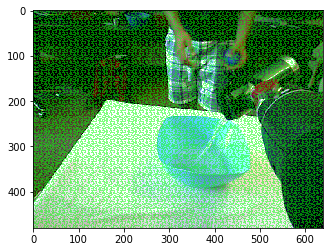

In [21]:
tf.reset_default_graph()
    
with tf.Session() as session:
    # Restore variables and model
    saver = tf.train.import_meta_graph("./model.ckpt.meta")
    print("Model restored.")
    
   
    # Get the three layers, keep probability and input layer
    graph = tf.get_default_graph()
    image_input = graph.get_tensor_by_name('image_input:0')
    keep_prob = graph.get_tensor_by_name('keep_prob:0')
    layer3 = graph.get_tensor_by_name('layer3_out:0')
    layer4 = graph.get_tensor_by_name('layer4_out:0')
    layer7 = graph.get_tensor_by_name('layer7_out:0')

    # The resulting network architecture, adding a decoder on top of the given vgg model
    model_output = layers(layer3, layer4, layer7, NUMBER_OF_CLASSES)

    logits = tf.reshape(model_output, (-1, NUMBER_OF_CLASSES))
    print('Graph constructed')
    
    # Initilize all variables
    session.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
    print('Variables initialized')
    
    # Restore variables that were trained from previous session
    saver.restore(session, tf.train.latest_checkpoint("./"))
    
    # TEST IMAGE
    test_image = scipy.misc.imresize(scipy.misc.imread("./data/data_liquid/testing/image_2/data0257.png"), IMAGE_SHAPE)
    
    # Make predictions
    feed = {keep_prob: 1.0, image_input: [test_image]}
    im_softmax = session.run( [tf.nn.softmax(logits)], feed)
    im_softmax = im_softmax[0][:, 1].reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1])
    segmentation = (im_softmax > 0.5).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 1)
    mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
    mask = scipy.misc.toimage(mask, mode="RGBA")
    result = scipy.misc.toimage(test_image)
    result.paste(mask, box=None, mask=mask)
    plt.imshow(result)
    plt.show()  
   
    
    #helper.save_inference_samples(RUNS_DIRECTORY, DATA_DIRECTORY, session, IMAGE_SHAPE, logits, keep_prob, image_input)

In [ ]:
def run_tests():
  print("NUMBER OF IMAGES:", NUMBER_OF_IMAGES)

  # download vgg model
  helper.maybe_download_pretrained_vgg(DATA_DIRECTORY)

  # A function to get batches
  get_batches_fn = helper.gen_batch_function(TRAINING_DATA_DIRECTORY, IMAGE_SHAPE)
  tf.reset_default_graph()
   
  with tf.Session() as session:
    
    # Restore variables and model
    saver = tf.train.import_meta_graph("./fcn_liquid_model-500.meta")
    saver.restore(session, tf.train.latest_checkpoint("./"))
    print("Model restored.")
    
     # Initilize all variables
    session.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
        
    # load the model and weights
    model = tf.saved_model.loader.load(session, ['vgg16'], VGG_PATH)

    # Get Tensors to be returned from graph
    graph = tf.get_default_graph()
    image_input = graph.get_tensor_by_name('image_input:0')
    keep_prob = graph.get_tensor_by_name('keep_prob:0')
    layer3 = graph.get_tensor_by_name('layer3_out:0')
    layer4 = graph.get_tensor_by_name('layer4_out:0')
    layer7 = graph.get_tensor_by_name('layer7_out:0')
    class_labels = tf.reshape(correct_label, (-1, NUMBER_OF_CLASSES))

    # The resulting network architecture, adding a decoder on top of the given vgg model
    model_output = layers(layer3, layer4, layer7, NUMBER_OF_CLASSES)
    
    # reshape 4D tensors to 2D
    # Each row represents a pixel, each column a class
    logits = tf.reshape(model_output, (-1, NUMBER_OF_CLASSES))
   

    # The cross_entropy_loss is the cost which we are trying to minimize to yield higher accuracy
    #cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = class_labels)
    #cross_entropy_loss = tf.reduce_mean(cross_entropy)

    # The model implements this operation to find the weights/parameters that would yield correct pixel labels
    #train_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy_loss)    
    
    # TEST IMAGE
    test_image = scipy.misc.imresize(scipy.misc.imread("./data/data_liquid/testing/image_2/data0257.png"), IMAGE_SHAPE)
    
    im_softmax = session.run(
            [tf.nn.softmax(logits)],
            {keep_prob: 1.0, image_input: [test_image]})
    """
    im_softmax = im_softmax[0][:, 1].reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1])
    segmentation = (im_softmax > 0.5).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 1)
    mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
    mask = scipy.misc.toimage(mask, mode="RGBA")
    result = scipy.misc.toimage(test_image)
    result.paste(mask, box=None, mask=mask)
    plt.imshow(result)
    plt.show() """
   
    # Save inference data
    #helper.save_inference_samples(RUNS_DIRECTORY, DATA_DIRECTORY, session, IMAGE_SHAPE, logits, keep_prob, image_input)    

In [ ]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

In [ ]:
def run_traintest():
  print("NUMBER OF IMAGES:", NUMBER_OF_IMAGES)

  # download vgg model
  helper.maybe_download_pretrained_vgg(DATA_DIRECTORY)

  # A function to get batches
  get_batches_fn = helper.gen_batch_function(TRAINING_DATA_DIRECTORY, IMAGE_SHAPE)

 
  
  with tf.Session() as session:
        
    # Returns the three layers, keep probability and input layer from the vgg architecture
    image_input, keep_prob, layer3, layer4, layer7 = load_vgg(session, VGG_PATH)

    # The resulting network architecture, adding a decoder on top of the given vgg model
    model_output = layers(layer3, layer4, layer7, NUMBER_OF_CLASSES)

    # Returns the output logits, training operation and cost operation to be used
    # For the logits: each row represents a pixel, each column a class
    # training operation is what is used to get the right parameters to the model to correctly label the pixels
    # the cross entropy loss is the cost which we are minimizing, lower cost should yield higher accuracy
    logits, train_op, cross_entropy_loss = optimize(model_output, correct_label, learning_rate, NUMBER_OF_CLASSES)
    
    # Create saver
    saver = tf.train.Saver()
    
    # Initilize all variables
    session.run([tf.global_variables_initializer(), tf.local_variables_initializer()])

    # train the neural network
    train_nn(session, EPOCHS, BATCH_SIZE, get_batches_fn, 
             train_op, cross_entropy_loss, image_input,
             correct_label, keep_prob, learning_rate)
    
    # Save inference data
    helper.save_inference_samples(RUNS_DIRECTORY, DATA_DIRECTORY, session, IMAGE_SHAPE, logits, keep_prob, image_input)    
    
    # Save model
    saver.save(session, "./fcn_liquid_model", global_step = 500)

In [ ]:
tf.reset_default_graph()

with tf.Session() as session:
    # Restore model graph
    saver = tf.train.import_meta_graph("./model.ckpt.meta")

    # Get the three layers, keep probability and input layer
    graph = tf.get_default_graph()
    image_input = graph.get_tensor_by_name('image_input:0')
    keep_prob = graph.get_tensor_by_name('keep_prob:0')
    layer3 = graph.get_tensor_by_name('layer3_out:0')
    layer4 = graph.get_tensor_by_name('layer4_out:0')
    layer7 = graph.get_tensor_by_name('layer7_out:0')

    # The resulting network architecture, adding a decoder on top of the given vgg model
    model_output = layers(layer3, layer4, layer7, NUMBER_OF_CLASSES)
    logits = tf.reshape(model_output, (-1, NUMBER_OF_CLASSES))
    print('Graph constructed')

	# Initialize all variables
    session.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
    print('Variables initialized')

    # Restore variables that were trained from previous session (a subset of all global & local variables).
    saver.restore(session, tf.train.latest_checkpoint("./"))
    print("Trained Variables restored from previous session.")
    
    print([n.name for n in tf.get_default_graph().as_graph_def().node])

    # load image
    test_image = scipy.misc.imresize(scipy.misc.imread("./data/data_liquid/testing/image_2/data0257.png"), IMAGE_SHAPE)

    # Make predictions
    feed = {keep_prob: 1.0, image_input: [test_image]}
    im_softmax = session.run( [tf.nn.softmax(logits)], feed)
    im_softmax = im_softmax[0][:, 1].reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1])
    segmentation = (im_softmax > 0.5).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 1)
    mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
    mask = scipy.misc.toimage(mask, mode="RGBA")
    result = scipy.misc.toimage(test_image)
    result.paste(mask, box=None, mask=mask)
    plt.imshow(result)
    plt.show()